In [38]:
import seaborn as sns
import cv2
import os
import pandas as pd
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from PIL import Image
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder
import warnings
import random
warnings.filterwarnings("ignore")




In [39]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

train_path = ('/kaggle/input/brain-tumor/brain-tumor/Training/')
test_path = ('/kaggle/input/brain-tumor/brain-tumor/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=data_transforms),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=data_transforms),
    batch_size=32, shuffle=False
)

train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [41]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

root2=pathlib.Path(test_path)
classes2=sorted([j.name.split('/')[-1] for j in root2.iterdir()])

print(f'The classes are: {classes}')
print(f'The classes are: {classes2}')

The classes are: ['notumor', 'tumor']
The classes are: ['notumor', 'tumor']


In [43]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
images.shape

torch.Size([27, 3, 224, 224])

In [46]:
train_img = []
train_labels = []
train_tumor = []
train_notumor = []

test_img = []
test_labels = []
test_tumor = []

for i in os.listdir(train_path): 
    for j in os.listdir(train_path+i):
        train_img.append (cv2.resize(cv2.imread(train_path+i+'/'+j), (224,224))) 
        if i == "tumor":
            train_tumor.append (cv2.resize(cv2.imread(train_path+i+'/'+j), (224,224))) 
        train_labels.append(i)
        
for i in os.listdir(test_path):
    for j in os.listdir(test_path+i):
        test_img.append (cv2.resize(cv2.imread(test_path+i+'/'+j), (224,224))) 
        if i == "tumor":
            test_tumor.append (cv2.resize(cv2.imread(test_path+i+'/'+j), (224,224))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
train_tumor = (np.array(train_tumor))
test_tumor = (np.array(test_tumor))
test_img = (np.array(test_img))

train_labels_encoded = [0 if category == 'no_tumor' else 1 for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else 1 for category in list(test_labels)]

print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (6107, 224, 224, 3)  and shape of test:  (1629, 224, 224, 3)


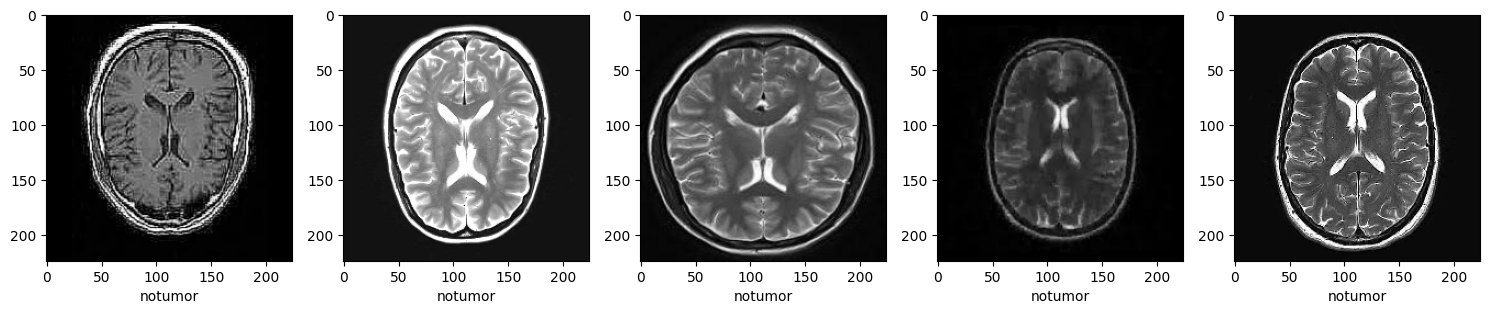

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(train_img[:5]):
    axes[i].imshow(img)
    axes[i].set_xlabel(train_labels[i])


plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(test_img[300:305]):
    axes[i].imshow(img)
    axes[i].set_xlabel(test_labels[i])


plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(test_tumor[100:105]):
    axes[i].imshow(img)
    axes[i].set_xlabel("tumor")


plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, img in enumerate(train_tumor[100:105]):
    axes[i].imshow(img)
    axes[i].set_xlabel("tumor")


plt.tight_layout()
plt.show()

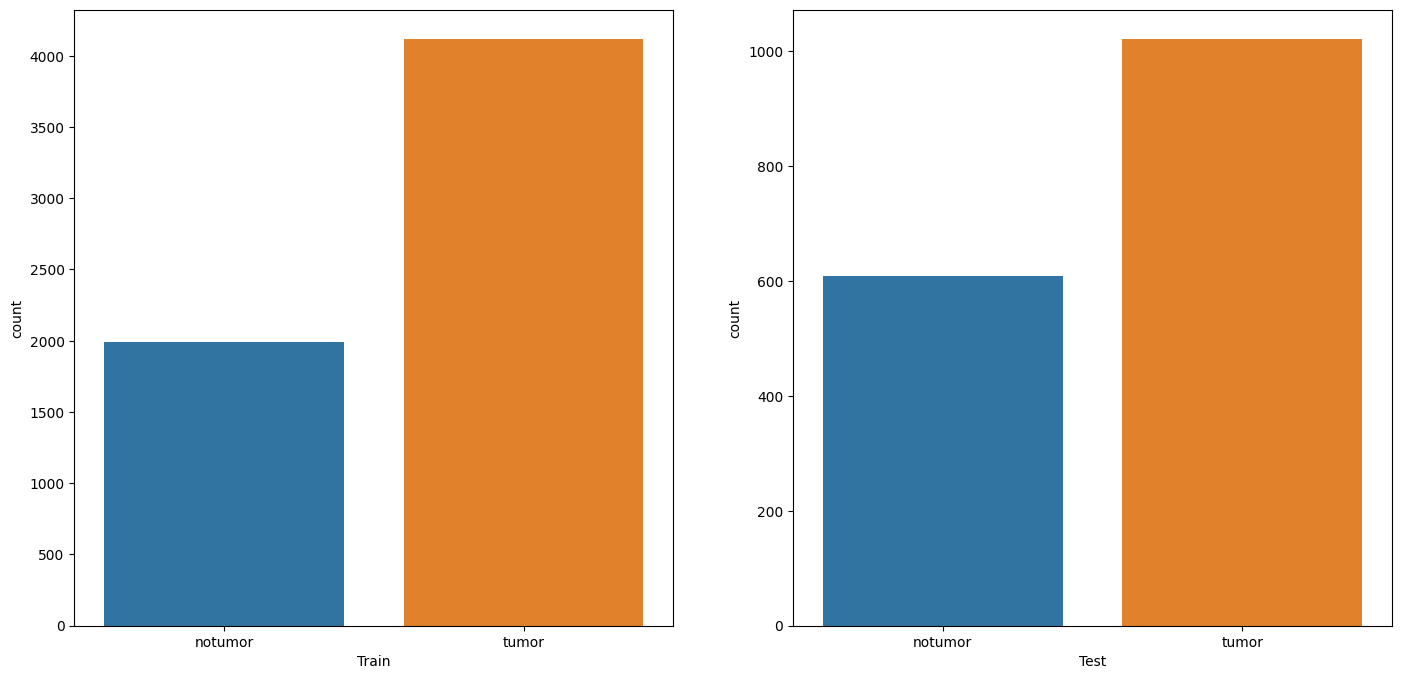

In [ ]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])